# Рубежный контроль №2

Терехова Вероника, группа ИУ5-65Б

| Номер варианта | Метод №1               | Метод №2            | Датасет
| -------------- | ---------------------- | --------------------|--------------------
| 17             | Метод опорных векторов | Градиентный бустинг | https://www.kaggle.com/mathan/fifa-2018-match-statistics

**Задание.** Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

In [142]:
# импорт основных библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [143]:
# импорт данных
data = pd.read_csv('FIFA 2018 Statistics.csv', sep=",")

Судя по названию, датасет создан для того, чтобы определить "лучшего игрока матча". Тогда будем режать задачу классификации: определять значение бинарного поля "Man of the March" (принадлежит ли лучший игрок команде) на основе всех остальных столбцов.

## Анализ датасета

In [144]:
print(f"Столбцов: {data.shape[0]}, строк: {data.shape[1]}")

Столбцов: 128, строк: 27


In [145]:
# типы данных столбцов
data.dtypes

Date                       object
Team                       object
Opponent                   object
Goal Scored                 int64
Ball Possession %           int64
Attempts                    int64
On-Target                   int64
Off-Target                  int64
Blocked                     int64
Corners                     int64
Offsides                    int64
Free Kicks                  int64
Saves                       int64
Pass Accuracy %             int64
Passes                      int64
Distance Covered (Kms)      int64
Fouls Committed             int64
Yellow Card                 int64
Yellow & Red                int64
Red                         int64
Man of the Match           object
1st Goal                  float64
Round                      object
PSO                        object
Goals in PSO                int64
Own goals                 float64
Own goal Time             float64
dtype: object

In [146]:
# первые 5 строк
data.head(5)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow Card,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,0,0,0,Yes,12.0,Group Stage,No,0,NaN,NaN
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,0,0,0,No,NaN,Group Stage,No,0,NaN,NaN
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,2,0,0,No,NaN,Group Stage,No,0,NaN,NaN
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,0,0,0,Yes,89.0,Group Stage,No,0,NaN,NaN
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,1,0,0,No,NaN,Group Stage,No,0,1.0,90.0


## Предобработка данных

In [147]:
# удаление дубликатов
data = data.drop_duplicates()

In [148]:
data.shape

(128, 27)

(дубликатов не было)

In [149]:
# проверка на наличие пропусков
data.isnull().sum()

Date                        0
Team                        0
Opponent                    0
Goal Scored                 0
Ball Possession %           0
Attempts                    0
On-Target                   0
Off-Target                  0
Blocked                     0
Corners                     0
Offsides                    0
Free Kicks                  0
Saves                       0
Pass Accuracy %             0
Passes                      0
Distance Covered (Kms)      0
Fouls Committed             0
Yellow Card                 0
Yellow & Red                0
Red                         0
Man of the Match            0
1st Goal                   34
Round                       0
PSO                         0
Goals in PSO                0
Own goals                 116
Own goal Time             116
dtype: int64

В столбце "1st Goal" интерпретируем пропуски как отсутствие голов в игре. <br>
В столбце "Own Goals" пропуск значит отсутствие автоголов. Так же и в столбце "Own goal Time". <br>
Поэтому в столбце с количеством голов можно заменить пропуски на 0.<br>
В остальных двух столбцах с пропусками так сделать нельзя, т.к. в них содержится время (гол на 0 минуте не то же самое, что отсутствие гола). Замена пропуска отрицательное или нечисловое значение затруднит обработку данных. Поэтому удалим их полностью.

In [150]:
data = data.drop(["1st Goal", "Own goal Time"], axis=1).fillna(0)
data.head(5)

,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Man of the Match,Round,PSO,Goals in PSO,Own goals
0,14-06-2018,Russia,Saudi Arabia,5,40,13,7,3,3,6,...,118,22,0,0,0,Yes,Group Stage,No,0,0.0
1,14-06-2018,Saudi Arabia,Russia,0,60,6,0,3,3,2,...,105,10,0,0,0,No,Group Stage,No,0,0.0
2,15-06-2018,Egypt,Uruguay,0,43,8,3,3,2,0,...,112,12,2,0,0,No,Group Stage,No,0,0.0
3,15-06-2018,Uruguay,Egypt,1,57,14,4,6,4,5,...,111,6,0,0,0,Yes,Group Stage,No,0,0.0
4,15-06-2018,Morocco,Iran,0,64,13,3,6,4,5,...,101,22,1,0,0,No,Group Stage,No,0,1.0


In [151]:
print(f"Пропусков: {data.isnull().sum().sum()}")

Пропусков: 0


Также откорректируем типы полей, которые заданы строками.

In [152]:
# перевод поля Man of Match в int
data["Man of the Match"] = data["Man of the Match"].replace("Yes", 1).replace("No", 0)

# перевод поля PSO в int
data["PSO"] = data["PSO"].replace("Yes", 1).replace("No", 0)

C:\Users\veronika\AppData\Local\Temp\ipykernel_19036\1040627372.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Man of the Match"] = data["Man of the Match"].replace("Yes", 1).replace("No", 0)
C:\Users\veronika\AppData\Local\Temp\ipykernel_19036\1040627372.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["PSO"] = data["PSO"].replace("Yes", 1).replace("No", 0)


In [153]:
from sklearn.preprocessing import LabelEncoder

In [154]:
le = LabelEncoder()
data["Team_le"] = le.fit_transform(data["Team"])
data["Opponent_le"] = le.fit_transform(data["Opponent"])
data["Round_le"] = le.fit_transform(data["Round"])

In [155]:
data.dtypes

Date                       object
Team                       object
Opponent                   object
Goal Scored                 int64
Ball Possession %           int64
Attempts                    int64
On-Target                   int64
Off-Target                  int64
Blocked                     int64
Corners                     int64
Offsides                    int64
Free Kicks                  int64
Saves                       int64
Pass Accuracy %             int64
Passes                      int64
Distance Covered (Kms)      int64
Fouls Committed             int64
Yellow Card                 int64
Yellow & Red                int64
Red                         int64
Man of the Match            int64
Round                      object
PSO                         int64
Goals in PSO                int64
Own goals                 float64
Team_le                     int32
Opponent_le                 int32
Round_le                    int32
dtype: object

In [156]:
dict(zip(np.unique(data["Team_le"]), data["Team"]))

{0: 'Russia',
 1: 'Saudi Arabia',
 2: 'Egypt',
 3: 'Uruguay',
 4: 'Morocco',
 5: 'Iran',
 6: 'Portugal',
 7: 'Spain',
 8: 'France',
 9: 'Australia',
 10: 'Argentina',
 11: 'Iceland',
 12: 'Peru',
 13: 'Denmark',
 14: 'Croatia',
 15: 'Nigeria',
 16: 'Costa Rica',
 17: 'Serbia',
 18: 'Germany',
 19: 'Mexico',
 20: 'Brazil',
 21: 'Switzerland',
 22: 'Sweden',
 23: 'Korea Republic',
 24: 'Belgium',
 25: 'Panama',
 26: 'Tunisia',
 27: 'England',
 28: 'Colombia',
 29: 'Japan',
 30: 'Poland',
 31: 'Senegal'}

In [157]:
dict(zip(np.unique(data["Opponent_le"]), data["Opponent"]))

{0: 'Saudi Arabia',
 1: 'Russia',
 2: 'Uruguay',
 3: 'Egypt',
 4: 'Iran',
 5: 'Morocco',
 6: 'Spain',
 7: 'Portugal',
 8: 'Australia',
 9: 'France',
 10: 'Iceland',
 11: 'Argentina',
 12: 'Denmark',
 13: 'Peru',
 14: 'Nigeria',
 15: 'Croatia',
 16: 'Serbia',
 17: 'Costa Rica',
 18: 'Mexico',
 19: 'Germany',
 20: 'Switzerland',
 21: 'Brazil',
 22: 'Korea Republic',
 23: 'Sweden',
 24: 'Panama',
 25: 'Belgium',
 26: 'England',
 27: 'Tunisia',
 28: 'Japan',
 29: 'Colombia',
 30: 'Senegal',
 31: 'Poland'}

In [158]:
dict(zip(np.unique(data["Round_le"]), data["Round"].unique()))

{0: 'Group Stage',
 1: 'Round of 16',
 2: 'Quarter Finals',
 3: 'Semi- Finals',
 4: '3rd Place',
 5: 'Final'}

## Решение задачи классификации

### Выборки для обучения и тестирования

In [159]:
from sklearn.model_selection import train_test_split

In [160]:
# поле Date содержит только одно значение, не учитываем для решения задачи


In [161]:
# исключаем необработанные строковые поля
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(["Date", "Team", "Opponent", "Round", "Man of the Match"], axis=1),
      data["Man of the Match"], test_size=0.2, random_state=1)

In [162]:
score = {}

In [163]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


In [164]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [165]:
def plot_cl(clf):
    title = clf.__repr__
    clf.fit(x_train.iloc[:, 0:2], y_train)
    fig, ax = plt.subplots(figsize=(5,5))
    X0, X1 = x_train.iloc[:, 0], x_train.iloc[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

### Метод опорных векторов

In [166]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [167]:
# Подбор гиперпараметров
# Для выбора используем метрику ROC AUC как хорошо сбалансированную и информативную
svc_rs = RandomizedSearchCV(SVC(), [{'C': list(map(lambda x: x / 10, range(1, 50, 1))), 
                                     "gamma": list(map(lambda x: x / 10, range(1, 50, 1))),
                                     "kernel": ['linear', 'poly', 'rbf']}],
                             cv=5)
svc_rs.fit(x_train, y_train)
svc_rs.best_estimator_, svc_rs.best_params_, svc_rs.best_score_

(SVC(C=1.3, gamma=1.6, kernel='linear'),
 {'kernel': 'linear', 'gamma': 1.6, 'C': 1.3},
 0.6766666666666667)

In [168]:
svc = svc_rs.best_estimator_

svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
score["Метод опорных векторов"] = {"precision": precision_score(y_test, y_pred),
                                   "recall": recall_score(y_test, y_pred),
                                    "f1": f1_score(y_test, y_pred),
                                    "roc_auc": roc_auc_score(y_test, y_pred)}

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


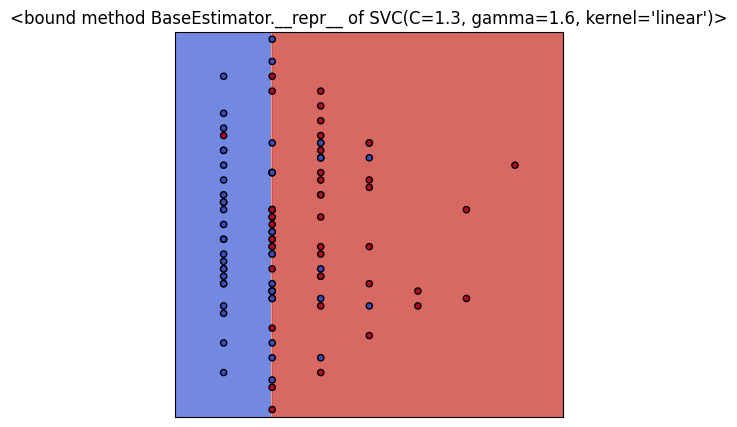

In [169]:
plot_cl(svc)

### Градиентный бустинг

In [170]:
from sklearn.ensemble import GradientBoostingClassifier

In [171]:
# Подбор гиперпараметров
gbc_rs = RandomizedSearchCV(GradientBoostingClassifier(),
                             [{'learning_rate': list(map(lambda x: x / 10, range(1, 100, 1))), 
                                "n_estimators": range(1, 200, 1)}],
                             cv=5)
gbc_rs.fit(x_train, y_train)
gbc_rs.best_estimator_, gbc_rs.best_params_, gbc_rs.best_score_

(GradientBoostingClassifier(learning_rate=2.9, n_estimators=108),
 {'n_estimators': 108, 'learning_rate': 2.9},
 0.6561904761904762)

In [172]:
gbs = gbc_rs.best_estimator_

gbs.fit(x_train, y_train)
y_pred = gbs.predict(x_test)
score["Градиентный бустинг"] = {"precision": precision_score(y_test, y_pred),
                                "recall": recall_score(y_test, y_pred),
                                "f1": f1_score(y_test, y_pred),
                                "roc_auc": roc_auc_score(y_test, y_pred)}

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


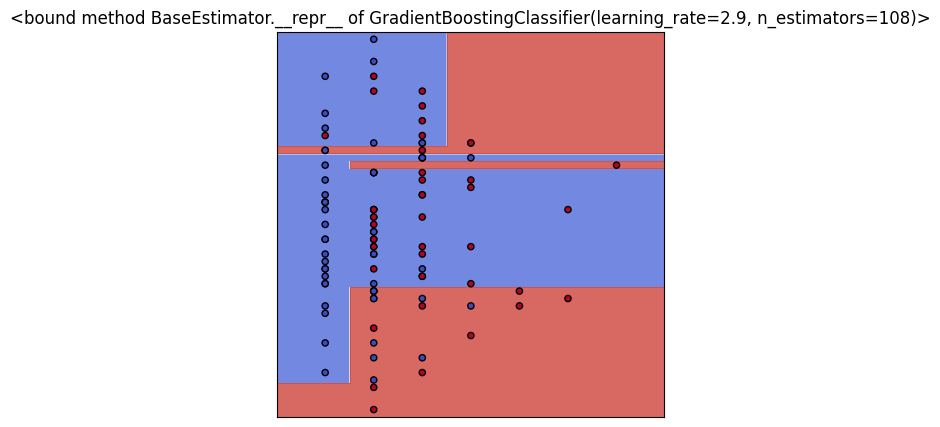

In [175]:
plot_cl(gbs)

### Сравнение моделей

Для анализа моделей используем как простые метрики precision, recall и более информативные f1 и roc_auc. Для их использования данные должны быть сбалансированны.

In [173]:
[data["Man of the Match"].value_counts(i) for i in data["Man of the Match"].unique()]

[Man of the Match
 1    0.5
 0    0.5
 Name: proportion, dtype: float64,
 Man of the Match
 1    64
 0    64
 Name: count, dtype: int64]

Данные хорошо сбалансированы.

In [174]:
pd.DataFrame(score).transpose()

,precision,recall,f1,roc_auc
Метод опорных векторов,0.833333,0.769231,0.800,0.807692
Градиентный бустинг,0.333333,0.076923,0.125,0.461538


### Вывод

На приведенном наборе данных метод опорных векторов показывает лучшие результаты, чем градиентный бустинг.